## Front-Door Criterion
**Hands‑on Notebook**


**In this notebook**
- Understand when back-door fails (unobserved confounder).
- Apply the front-door conditions.
- Compute the front-door formula step by step.

### 1. Theory: Front-door criterion
We sometimes cannot adjust for the confounder because it is **unobserved** (e.g. genetic predisposition).
If there is a mediator $Z$ such that:
1. $Z$ intercepts all directed paths from $X$ to $Y$,
2. there is no unblocked back-door path from $X$ to $Z$, and
3. all back-door paths from $Z$ to $Y$ are blocked by $X$,
then we can identify the causal effect using the **front-door adjustment**:

$$P(y \mid do(x)) = \sum_z P(z \mid x) \sum_{x'} P(y \mid x', z) P(x').$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(123)

![Backdoor Simple Graph](../images/frontdoorwithU.png)

In [2]:
# simulate smoking (X), tar (Z), cancer (Y) with unobserved U
N = 60_000
U = np.random.binomial(1, 0.5, size=N)  # unobserved risk factor

# X depends on U
p_x = np.where(U == 1, 0.8, 0.2)
X = np.random.binomial(1, p_x)

# Z (tar) depends on X only (condition 2 of front-door)
p_z = np.where(X == 1, 0.9, 0.1)
Z = np.random.binomial(1, p_z)

# Y depends on Z and U (so U is a confounder we cannot adjust for directly)
Z_EFFECT = 0.25  # Effect of Z (tar) on Y (cancer)
Y_prob = 0.05 + Z_EFFECT * Z + 0.25 * U
Y_prob = np.clip(Y_prob, 0, 1)
Y = np.random.binomial(1, Y_prob)

# True causal effect of X on Y (through Z)
# E[Z|do(X=1)] - E[Z|do(X=0)] = 0.9 - 0.1 = 0.8
# True effect = 0.8 * 0.25 = 0.2
TRUE_EFFECT = 0.8 * Z_EFFECT

df_fd = pd.DataFrame({'X': X, 'Z': Z, 'Y': Y, 'U': U})
df_fd.head()

,X,Z,Y,U
0,0,0,1,1
1,0,0,0,0
2,0,0,0,0
3,1,1,1,1
4,1,1,1,1


### 2. Naive estimate (will be biased)
Because U affects both X and Y, the simple comparison of smokers vs non-smokers will not recover the true effect.

In [3]:
p_y_x1 = df_fd.loc[df_fd.X == 1, 'Y'].mean()
p_y_x0 = df_fd.loc[df_fd.X == 0, 'Y'].mean()
naive_effect = p_y_x1 - p_y_x0

print(f"Naive estimate: {naive_effect:.3f} (BIASED due to hidden confounder U)")
print(f"True effect:    {TRUE_EFFECT:.3f} (causal effect through mediator Z)")
naive_effect

Naive estimate: 0.350 (BIASED due to hidden confounder U)
True effect:    0.200 (causal effect through mediator Z)


0.3499369260927919

### 3. Front-door estimation step by step
We implement
$$P(y \mid do(x)) = \sum_z P(z \mid x) \sum_{x'} P(y \mid x', z) P(x').$$

In [4]:
def front_door_effect(df, x_val=1):
    """
    Compute P(Y=1 | do(X=x_val)) using the front-door formula:
    P(y | do(x)) = ∑_z P(z|x) · ∑_{x'} P(y|x',z) · P(x')
    """
    
    # Step 1: Compute P(x') - the marginal distribution of X
    # This gives us the probability of each treatment value in the population
    p_xprime = df['X'].value_counts(normalize=True).sort_index()
    
    # Step 2: Compute P(z|x) - probability of mediator Z given treatment X
    # This captures how X affects Z (first stage of the causal chain)
    p_z_given_x = (
        df.groupby(['X', 'Z']).size()
        / df.groupby('X').size()
    ).unstack(fill_value=0)
    
    # Step 3: Compute P(y|x',z) - probability of outcome given treatment and mediator
    # This captures how Z affects Y, adjusting for confounding through X
    p_y_given_xz = (
        df.groupby(['X', 'Z'])['Y'].mean()
        .unstack(fill_value=0)
    )
    
    # Step 4: Implement the front-door formula with nested summations
    total = 0.0
    
    # Outer sum: over mediator values z
    for z_val in [0, 1]:
        # Get P(z|x) for this specific z value
        p_z_given_xval = p_z_given_x.loc[x_val, z_val]
        
        # Inner sum: ∑_{x'} P(y|x',z) · P(x')
        # This averages out the effect of the confounder U
        inner_sum = 0.0
        for xprime, pxp in p_xprime.items():
            # P(y|x',z) for this combination of x' and z
            py_xprime_z = p_y_given_xz.loc[xprime, z_val]
            # Weight by P(x')
            inner_sum += py_xprime_z * pxp
        
        # Multiply by P(z|x) and add to total
        total += p_z_given_xval * inner_sum
    
    return total

# Compute causal effect using front-door adjustment
p_y_do1 = front_door_effect(df_fd, x_val=1)  # P(Y=1 | do(X=1))
p_y_do0 = front_door_effect(df_fd, x_val=0)  # P(Y=1 | do(X=0))
fd_effect = p_y_do1 - p_y_do0  # Causal effect

print(f"Naive estimate:     {naive_effect:.3f} (BIASED)")
print(f"Front-door estimate: {fd_effect:.3f} (UNBIASED)")
print(f"True effect:        {TRUE_EFFECT:.3f} (set in data generation)")
#fd_effect

Naive estimate:     0.350 (BIASED)
Front-door estimate: 0.195 (UNBIASED)
True effect:        0.200 (set in data generation)


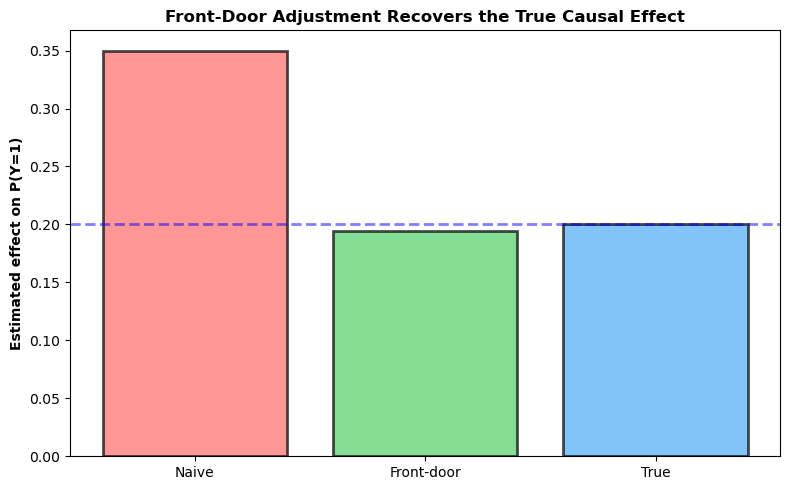

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Naive', 'Front-door', 'True'], [naive_effect, fd_effect, TRUE_EFFECT],
       color=['#ff6b6b', '#51cf66', '#4dabf7'], alpha=0.7, edgecolor='black', linewidth=2)
ax.axhline(y=TRUE_EFFECT, color='blue', linestyle='--', linewidth=2, alpha=0.5)
ax.set_ylabel('Estimated effect on P(Y=1)', fontweight='bold')
ax.set_title('Front-Door Adjustment Recovers the True Causal Effect', fontweight='bold')
plt.tight_layout()
plt.show()

### 4. Exercises
Change the strength of the hidden confounder U and discuss what happens.


In [6]:
# simulate smoking (X), tar (Z), cancer (Y) with unobserved U
N = 60_000
U = np.random.binomial(1, 0.5, size=N)  # unobserved risk factor

# X depends on U
p_x = np.where(U == 1, 0.5, 0.9)
X = np.random.binomial(1, p_x)

# Z (tar) depends on X only (condition 2 of front-door)
p_z = np.where(X == 1, 0.9, 0.1)
Z = np.random.binomial(1, p_z)

# Y depends on Z and U (so U is a confounder we cannot adjust for directly)
Z_EFFECT = 0.25  # Effect of Z (tar) on Y (cancer)
Y_prob = 0.05 + Z_EFFECT * Z + 0.25 * U
Y_prob = np.clip(Y_prob, 0, 1)
Y = np.random.binomial(1, Y_prob)

# True causal effect of X on Y (through Z)
# E[Z|do(X=1)] - E[Z|do(X=0)] = 0.9 - 0.1 = 0.8
# True effect = 0.8 * 0.25 = 0.2
TRUE_EFFECT = 0.8 * Z_EFFECT

df_fd = pd.DataFrame({'X': X, 'Z': Z, 'Y': Y, 'U': U})
df_fd.head()

,X,Z,Y,U
0,1,1,1,0
1,0,0,0,1
2,1,1,1,1
3,1,1,0,1
4,1,1,0,0


In [7]:
p_y_x1 = df_fd.loc[df_fd.X == 1, 'Y'].mean()
p_y_x0 = df_fd.loc[df_fd.X == 0, 'Y'].mean()
naive_effect = p_y_x1 - p_y_x0

print(f"Naive estimate: {naive_effect:.3f} (BIASED due to hidden confounder U)")
print(f"True effect:    {TRUE_EFFECT:.3f} (causal effect through mediator Z)")
naive_effect

Naive estimate: 0.079 (BIASED due to hidden confounder U)
True effect:    0.200 (causal effect through mediator Z)


0.07896610384058816

In [8]:
def front_door_effect(df, x_val=1):
    """
    Compute P(Y=1 | do(X=x_val)) using the front-door formula:
    P(y | do(x)) = ∑_z P(z|x) · ∑_{x'} P(y|x',z) · P(x')
    """
    
    # Step 1: Compute P(x') - the marginal distribution of X
    # This gives us the probability of each treatment value in the population
    p_xprime = df['X'].value_counts(normalize=True).sort_index()
    
    # Step 2: Compute P(z|x) - probability of mediator Z given treatment X
    # This captures how X affects Z (first stage of the causal chain)
    p_z_given_x = (
        df.groupby(['X', 'Z']).size()
        / df.groupby('X').size()
    ).unstack(fill_value=0)
    
    # Step 3: Compute P(y|x',z) - probability of outcome given treatment and mediator
    # This captures how Z affects Y, adjusting for confounding through X
    p_y_given_xz = (
        df.groupby(['X', 'Z'])['Y'].mean()
        .unstack(fill_value=0)
    )
    
    # Step 4: Implement the front-door formula with nested summations
    total = 0.0
    
    # Outer sum: over mediator values z
    for z_val in [0, 1]:
        # Get P(z|x) for this specific z value
        p_z_given_xval = p_z_given_x.loc[x_val, z_val]
        
        # Inner sum: ∑_{x'} P(y|x',z) · P(x')
        # This averages out the effect of the confounder U
        inner_sum = 0.0
        for xprime, pxp in p_xprime.items():
            # P(y|x',z) for this combination of x' and z
            py_xprime_z = p_y_given_xz.loc[xprime, z_val]
            # Weight by P(x')
            inner_sum += py_xprime_z * pxp
        
        # Multiply by P(z|x) and add to total
        total += p_z_given_xval * inner_sum
    
    return total

# Compute causal effect using front-door adjustment
p_y_do1 = front_door_effect(df_fd, x_val=1)  # P(Y=1 | do(X=1))
p_y_do0 = front_door_effect(df_fd, x_val=0)  # P(Y=1 | do(X=0))
fd_effect = p_y_do1 - p_y_do0  # Causal effect

print(f"Naive estimate:     {naive_effect:.3f} (BIASED)")
print(f"Front-door estimate: {fd_effect:.3f} (UNBIASED)")
print(f"True effect:        {TRUE_EFFECT:.3f} (set in data generation)")
#fd_effect

Naive estimate:     0.079 (BIASED)
Front-door estimate: 0.204 (UNBIASED)
True effect:        0.200 (set in data generation)


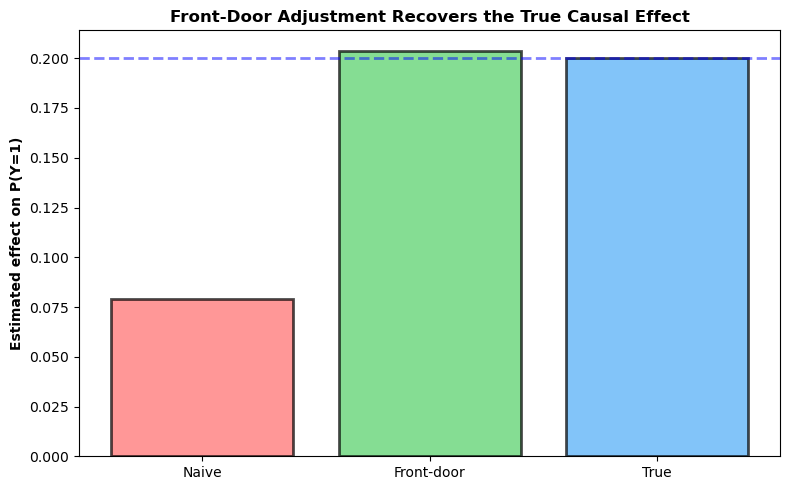

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Naive', 'Front-door', 'True'], [naive_effect, fd_effect, TRUE_EFFECT],
       color=['#ff6b6b', '#51cf66', '#4dabf7'], alpha=0.7, edgecolor='black', linewidth=2)
ax.axhline(y=TRUE_EFFECT, color='blue', linestyle='--', linewidth=2, alpha=0.5)
ax.set_ylabel('Estimated effect on P(Y=1)', fontweight='bold')
ax.set_title('Front-Door Adjustment Recovers the True Causal Effect', fontweight='bold')
plt.tight_layout()
plt.show()

This adjustment has changed the Naive, Front-door and True dramatically.  